Импорт библиотек

In [2]:
import pandas as pd

import statsmodels.api as sm
from statsmodels.tsa.api import adfuller
from statsmodels.tsa.stattools import pacf,acf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults


from scipy.stats import linregress

from IPython.display import display, Markdown
import matplotlib.pyplot as plt

In [3]:
f=open('идз.txt')
v=f.read().split(',')
df=pd.DataFrame(data=v,index=range(1,len(v)+1),dtype=float)
df.rename(columns={0:'value'},inplace=True)

Визуализация ряда:

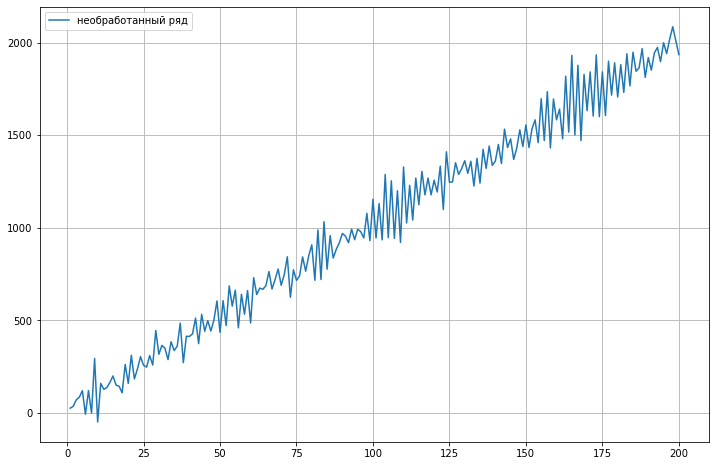

In [4]:
fig,ax=plt.subplots(figsize=(12,8))
ax.plot(df.index,df.value,label='необработанный ряд')
ax.legend()
ax.grid()
plt.savefig('raw data.png')
plt.show()

### Процедура Доладо-Дженкинса-Сосвилла-Риверо

#### Первый шаг 
Оцениваем модель  
$X_t=\mu+bt+\sum^{p}_{i=1}\alpha_i X_{t-i}+\varepsilon_t$, где $\varepsilon_t \sim WN(0, \sigma^2)$  
Порядок $p$ выбираем из условия $p<n^{\frac{1}{3}}$, $n$ - кол-во наблюдений

При помощи ADF теста проверяется гипотеза  
$H_0 : \alpha_1=1$
против альтернативы
$H_1 : \alpha_1<1$

Оценим статистику, выбирая кол-во лагов для минимизации информационного критерия Шварца:

In [5]:
adf_res=adfuller(df,regression='ct', autolag='BIC')
print('Value of test statistics = ',adf_res[0])
print('P value = ',adf_res[1])
print('Number of significant lags = ',adf_res[2])

Value of test statistics =  -10.715586536576291
P value =  7.905201010148822e-17
Number of significant lags =  1


Отвергаем нулевую гипотезу о наличии случайного блуждания с дрейфом $\rightarrow$ ряд типа TSP;  
Процедура Доладо-Дженкинса-Сосвилла-Риверо останавливается

#### Построение МНК для оценки тренда

Тестируем $\beta$:  
$H_0$:$\beta=0$  
$H_1$:$\beta\neq0$

In [6]:
res=linregress(x=df.index,y=df.value)
print(f'Intercept: {res.intercept:.6f}')
print(f'Slope: {res.slope:.6f}')
print(f'P-value Wald Test: {res.pvalue}')
print(f"R-squared: {res.rvalue**2:.6f}")

Intercept: 26.272823
Slope: 9.920467
P-value Wald Test: 4.377792543555319e-163
R-squared: 0.976419


In [7]:
from scipy.stats import t
tinv = lambda p, df: abs(t.ppf(p/2, df))
ts = tinv(0.05, len(df.index)-2)
print(f"slope (95%): {res.slope:.6f} +/- {ts*res.stderr:.6f}")
print(f"intercept (95%): {res.intercept:.6f}"
      f" +/- {ts*res.intercept_stderr:.6f}")

slope (95%): 9.920467 +/- 0.216058
intercept (95%): 26.272823 +/- 25.041758


Убираем тренд

In [8]:
df_no_trend=df.value-(res.intercept + pd.Series(res.slope*df.index,index=df.index))

Проверка на стационарность детрендированного ряда:

In [9]:
print('P-value ADF:',adfuller(df_no_trend,regression='c')[1])

P-value ADF: 2.75707926951659e-19


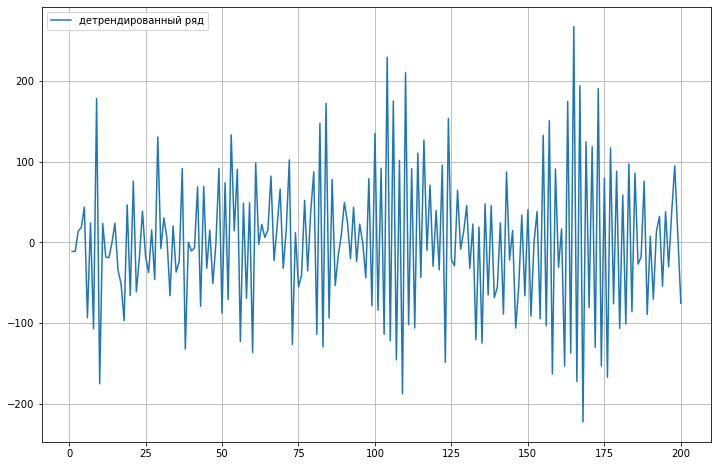

In [10]:
fig,ax=plt.subplots(figsize=(12,8))
ax.plot(df_no_trend.index,df_no_trend,label='детрендированный ряд')
ax.legend()
ax.grid()
plt.savefig('detrended series.png')
plt.show()

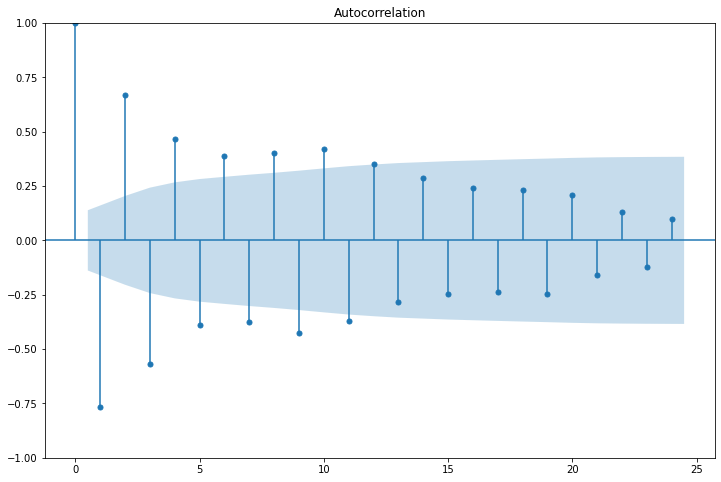

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_acf(df_no_trend,ax=ax)
plt.savefig('ACF_detrended_series.png')
plt.show()

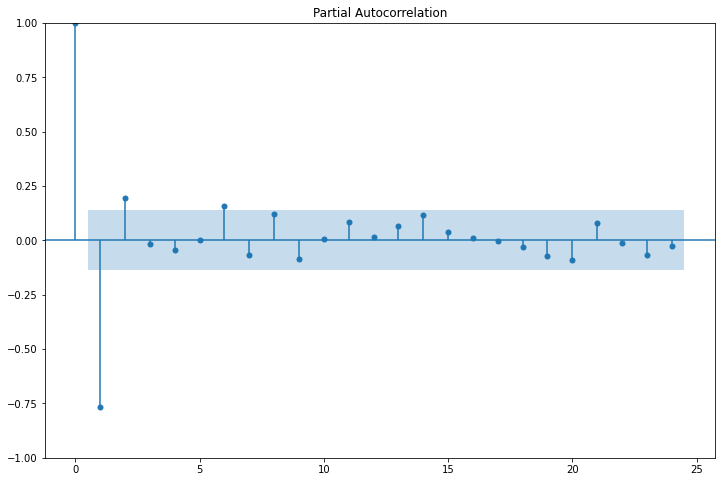

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_pacf(df_no_trend,ax=ax,method='ywm')
plt.savefig('PACF_detrended_series.png')
plt.show()

In [13]:
AR2=ARIMA(df_no_trend,order=(2,0,0),trend='n')
AR2.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  200
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1089.583
Date:                Wed, 22 Mar 2023   AIC                           2185.167
Time:                        12:02:01   BIC                           2195.062
Sample:                             0   HQIC                          2189.171
                                - 200                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6154      0.072     -8.580      0.000      -0.756      -0.475
ar.L2          0.1929      0.074      2.600      0.009       0.047       0.338
sigma2      3143.8876    345.867      9.090      0.000    2466.000    3821.775
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.12
Prob(Q):                              0.98   Prob(JB):                         0.57
Heteroskedasticity (H):               1.10   Skew:                             0.10
Prob(H) (two-sided):                  0.70   Kurtosis:                         2.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
AR1MA1=ARIMA(df_no_trend,order=(1,0,1),trend='n')
AR1MA1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  200
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1089.787
Date:                Wed, 22 Mar 2023   AIC                           2185.574
Time:                        12:02:01   BIC                           2195.469
Sample:                             0   HQIC                          2189.578
                                - 200                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8578      0.048    -17.922      0.000      -0.952      -0.764
ma.L1          0.2344      0.097      2.416      0.016       0.044       0.424
sigma2      3150.4313    354.862      8.878      0.000    2454.915    3845.948
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.35
Prob(Q):                              0.93   Prob(JB):                         0.51
Heteroskedasticity (H):               1.11   Skew:                             0.11
Prob(H) (two-sided):                  0.67   Kurtosis:                         2.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
AR2MA1=ARIMA(df_no_trend,order=(2,0,1),trend='n')
AR2MA1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  200
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -1089.578
Date:                Wed, 22 Mar 2023   AIC                           2187.157
Time:                        12:02:01   BIC                           2200.350
Sample:                             0   HQIC                          2192.496
                                - 200                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6448      0.411     -1.570      0.116      -1.450       0.160
ar.L2          0.1704      0.317      0.538      0.591      -0.451       0.792
ma.L1          0.0307      0.419      0.073      0.942      -0.791       0.852
sigma2      3143.7994    353.740      8.887      0.000    2450.482    3837.117
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.16
Prob(Q):                              0.97   Prob(JB):                         0.56
Heteroskedasticity (H):               1.10   Skew:                             0.10
Prob(H) (two-sided):                  0.70   Kurtosis:                         2.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
AR2.fit().save('model.pkl')
loaded_AR2=ARIMAResults.load('model.pkl')

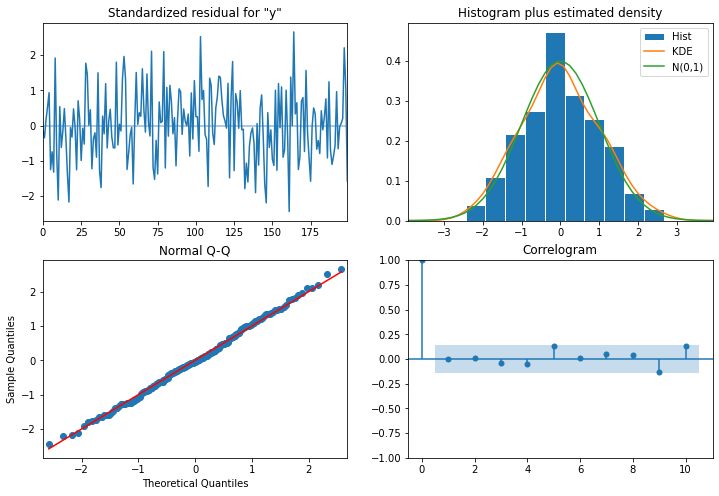

In [17]:
diagnostics=loaded_AR2.plot_diagnostics(figsize=(12,8))

In [18]:
diagnostics.savefig('diagnostics.png')

#### Предсказание

In [19]:
AR2_pred=AR2.fit().predict(200)

In [20]:
m_pred = 26.272823+ 9.920467*201

In [21]:
pred=pd.DataFrame(AR2_pred+m_pred).rename(columns={0:'value'})

C:\Users\densm\AppData\Local\Temp\ipykernel_11984\379004116.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df.append(pred).plot()


<AxesSubplot:>

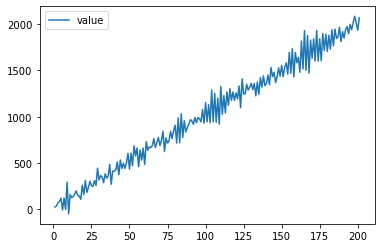

In [22]:
df.append(pred).plot()